<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

As well see in the [distributed scheduler notebook](05_distributed.ipynb), Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.Client`. For now, this will provide us with some nice diagnostics. We'll talk about schedulers in depth later.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

## 基本

首先让我们制作一些玩具功能，例如inc和add，它们会休眠一段时间以模拟工作。 然后，我们将正常运行这些功能。

在下一节中，我们将并行化此代码。


In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 217 ms, sys: 11.4 ms, total: 228 ms
Wall time: 3 s


### 使用`dask.delayed`装饰器并行

可以并行调用这两个增量调用，因为它们完全彼此独立。

我们将使用`dask.delayed`函数来转换`inc`和`add`函数。 当我们通过传递参数来调用延迟版本时，与以前完全一样，但是实际上尚未调用原始函数-这就是为什么单元执行非常快地完成的原因。
而是创建了一个“延迟对象”，该对象跟踪要调用的函数以及要传递给该函数的参数。

In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 0 ns, sys: 2.57 ms, total: 2.57 ms
Wall time: 2.22 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 197 ms, sys: 19.7 ms, total: 216 ms
Wall time: 2.05 s


5

## 刚才发生了什么？

`z`对象是一个懒惰(`lazy`)的`Delayed`对象。 该对象包含我们计算最终结果所需的一切，包括对所有必需功能的引用以及它们的输入以及与另一个函数的关系。 我们可以如上所述使用`.compute()`评估结果，也可以使用`.visualize()`可视化该值的任务图。

In [7]:
z

Delayed('add-beec25f1-cff1-4405-996f-95d51c3054a3')

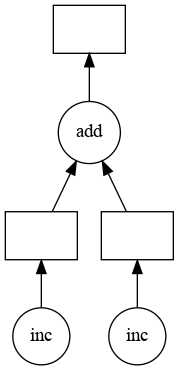

In [8]:
# Look at the task graph for `z`
# 需要安装graphviz:   sudo apt install graphviz
z.visualize()

注意，这包括之前的函数名称，以及`inc`函数的输出到`add`的输入的逻辑流程。

### 需要考虑的一些问题：

-为什么我们从3秒变成2秒？ 为什么我们不能并行化到1s？  
-如果inc和add函数不包含`sleep(1)`会发生什么？ Dask仍然可以加快此代码的速度吗？  
-如果我们有多个输出或者还想访问`x`或`y`，该怎么办？  

## 练习：并行处理for循环

`for`循环是我们要并行化的最常见的事物之一。 在`inc`和`sum`上使用`dask.delayed`来并行化以下计算：

In [9]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [10]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 624 ms, sys: 59.3 ms, total: 684 ms
Wall time: 8.01 s


In [11]:
total

44

In [16]:
%%time
# Your parallel code here...
results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
result = total.compute()
print(result)

44
CPU times: user 108 ms, sys: 8.39 ms, total: 116 ms
Wall time: 1.06 s


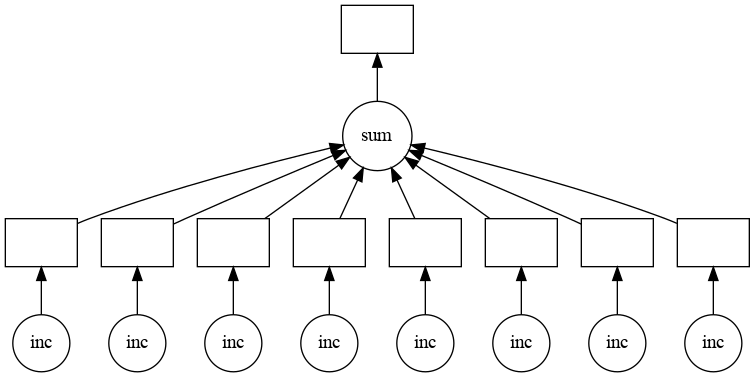

In [17]:
total.visualize()

In [18]:
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-6525457d-71f0-4fcb-98ec-b2b88024ab33')
After computing : 44


与直接使用“`sum`函数而不是用`delayed`包装的版本相比，图形可视化如何与给定的解决方案进行比较？ 您能解释下一个版本吗？ 您可能会发现以下表达式的结果
```python
delayed(inc)(1) + delayed(inc)(2)
```

In [21]:
%%time
# Your parallel code here...
results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = sum(results)  # 不使用delayed(sum)
result = total.compute()
print(result)

44
CPU times: user 111 ms, sys: 31.8 ms, total: 142 ms
Wall time: 1.09 s


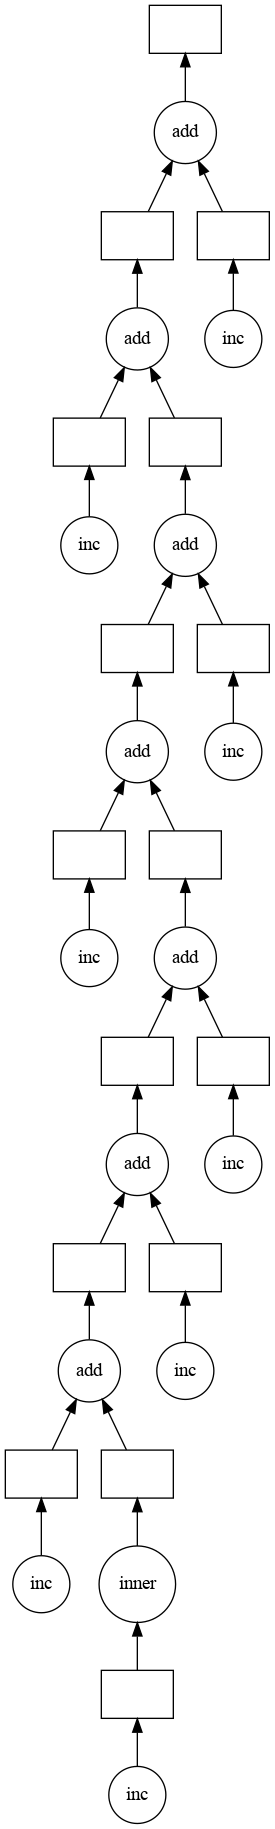

In [22]:
total.visualize()

## 练习：使用控制流并行处理for循环代码

通常，我们只希望延迟*某些*功能，立即运行其中一些功能。当这些函数快速运行并帮助我们确定应该调用哪些其他较慢的函数时，这特别有用。这个决定，延迟或不延迟，通常是我们在使用`dask.delayed`时需要考虑的地方。

在下面的示例中，我们遍历输入列表。 如果输入是偶数，那么我们要调用`inc`。 如果输入为奇数，则我们要调用`double`。 必须立即（而不是懒惰地）做出决定调用` inc`或`double`的`is_even`，以便我们的图形构建Python代码继续进行。

In [27]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [28]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 781 ms, sys: 81.9 ms, total: 863 ms
Wall time: 10 s


In [35]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all
results = []
for x in data:
    if delayed(is_even)(x):   #如果在这里错误地使用了delayed
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print(total.compute())
total.visualize()

TypeError: Truth of Delayed objects is not supported

In [31]:
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

In [32]:
%time total.compute()

CPU times: user 131 ms, sys: 5.17 ms, total: 137 ms
Wall time: 1.05 s


90

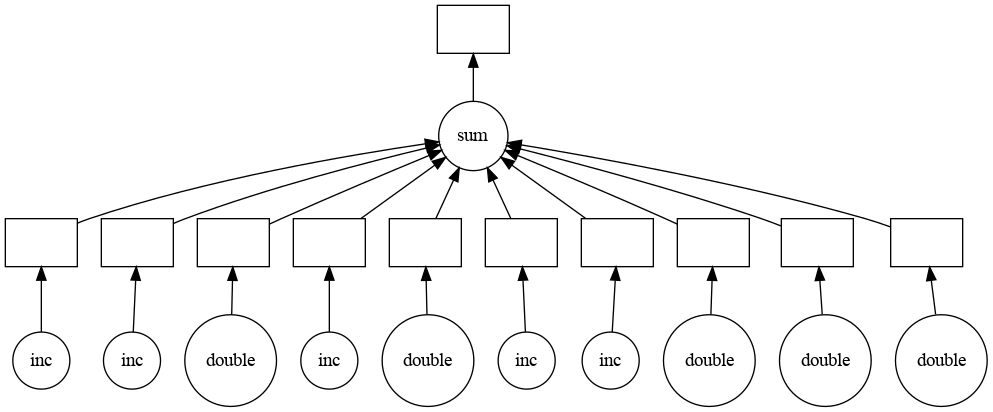

In [33]:
total.visualize()

### 需要考虑的一些问题：

- 还有哪些我们不能使用延迟的控制流示例？
- 如果在上面的示例中延迟了对`is_even（x）`的求值，将会发生什么？
- 您对延迟`sum`有何想法？ 此函数既具有计算能力，又具有运行速度快。

## 练习：并行化Pandas Groupby Reduction

在本练习中，我们读取了多个CSV文件并并行执行groupby操作。 我们获得了顺序代码来执行此操作，并将其与`dask.delayed`并行化。

我们将并行进行的计算是根据一些历史飞行数据来计算每个机场的平均离港延误。 我们将通过使用`dask.delayed`和`pandas`来做到这一点。 在以后的部分中，我们将使用`dask.dataframe`进行相同的练习。

## 创建数据

运行此代码以准备一些数据。

此下载并提取了1990年到2000年之间纽约市以外航班的一些历史航班数据。数据最初来自[这里]（http://stat-computing.org/dataexpo/2009/the-data.html）。

In [38]:
%run prep.py -d flights

- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Created flights dataset! in 6.45s**


### 检查数据

In [39]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

### 用`pandas.read_csv`读取一个文件并计算平均出发延迟

In [40]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [41]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [43]:
# 数据中包含哪些始发机场？
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [44]:
# 每个机场的年平均离港延误
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### 顺序代码：每个机场的平均离港延误

上面的单元格计算了每个机场一年的平均起飞延迟。 在这里，我们使用顺序for循环将其扩展到所有年份。

In [45]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [47]:
%%time

sums = []
counts = []
for fn in filenames:
    # 读入文件
    df = pd.read_csv(fn)
    
    # Groupby出发地机场
    by_origin = df.groupby('Origin')
    
    # 所有始发航班延误的总和
    total = by_origin.DepDelay.sum()
    
    # 始发航班数
    count = by_origin.DepDelay.count()
    
    # 保存中间变量
    sums.append(total)
    counts.append(count)

# 合并中间量以获得总的平均始发延迟
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 2.38 s, sys: 83.8 ms, total: 2.46 s
Wall time: 2.39 s


In [48]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### 并行化上面的代码

使用`dask.delayed`并行化上面的代码。 您需要了解一些额外的信息。

1.  对delayed对象的方法和属性访问会自动工作，因此，如果您有delayed对象，则可以对其执行常规的算术，切片和方法调用，它将产生正确的延迟调用。

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # 这里的一切都delayed了
    ```
2.  当您只有一个输出时，调用`.compute（）`方法效果很好。 当您有多个输出时，您可能想使用`dask.compute`函数：

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    这样Dask可以共享中间值（例如`y = x ** 2`）
    
因此，您的目标是使用`dask.delayed`并行化上面的代码（已在下面复制）。 您可能还需要可视化一些计算，以查看是否正确执行了计算。

In [49]:
from dask import compute

In [54]:
%%time

# 复制的顺序代码

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = delayed(sum)(sums)
n_flights = delayed(sum)(counts)
def div(a,b):
    return a/b

mean = delayed(div)(total_delays,n_flights)
mean.compute()

CPU times: user 176 ms, sys: 12.6 ms, total: 189 ms
Wall time: 1.51 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

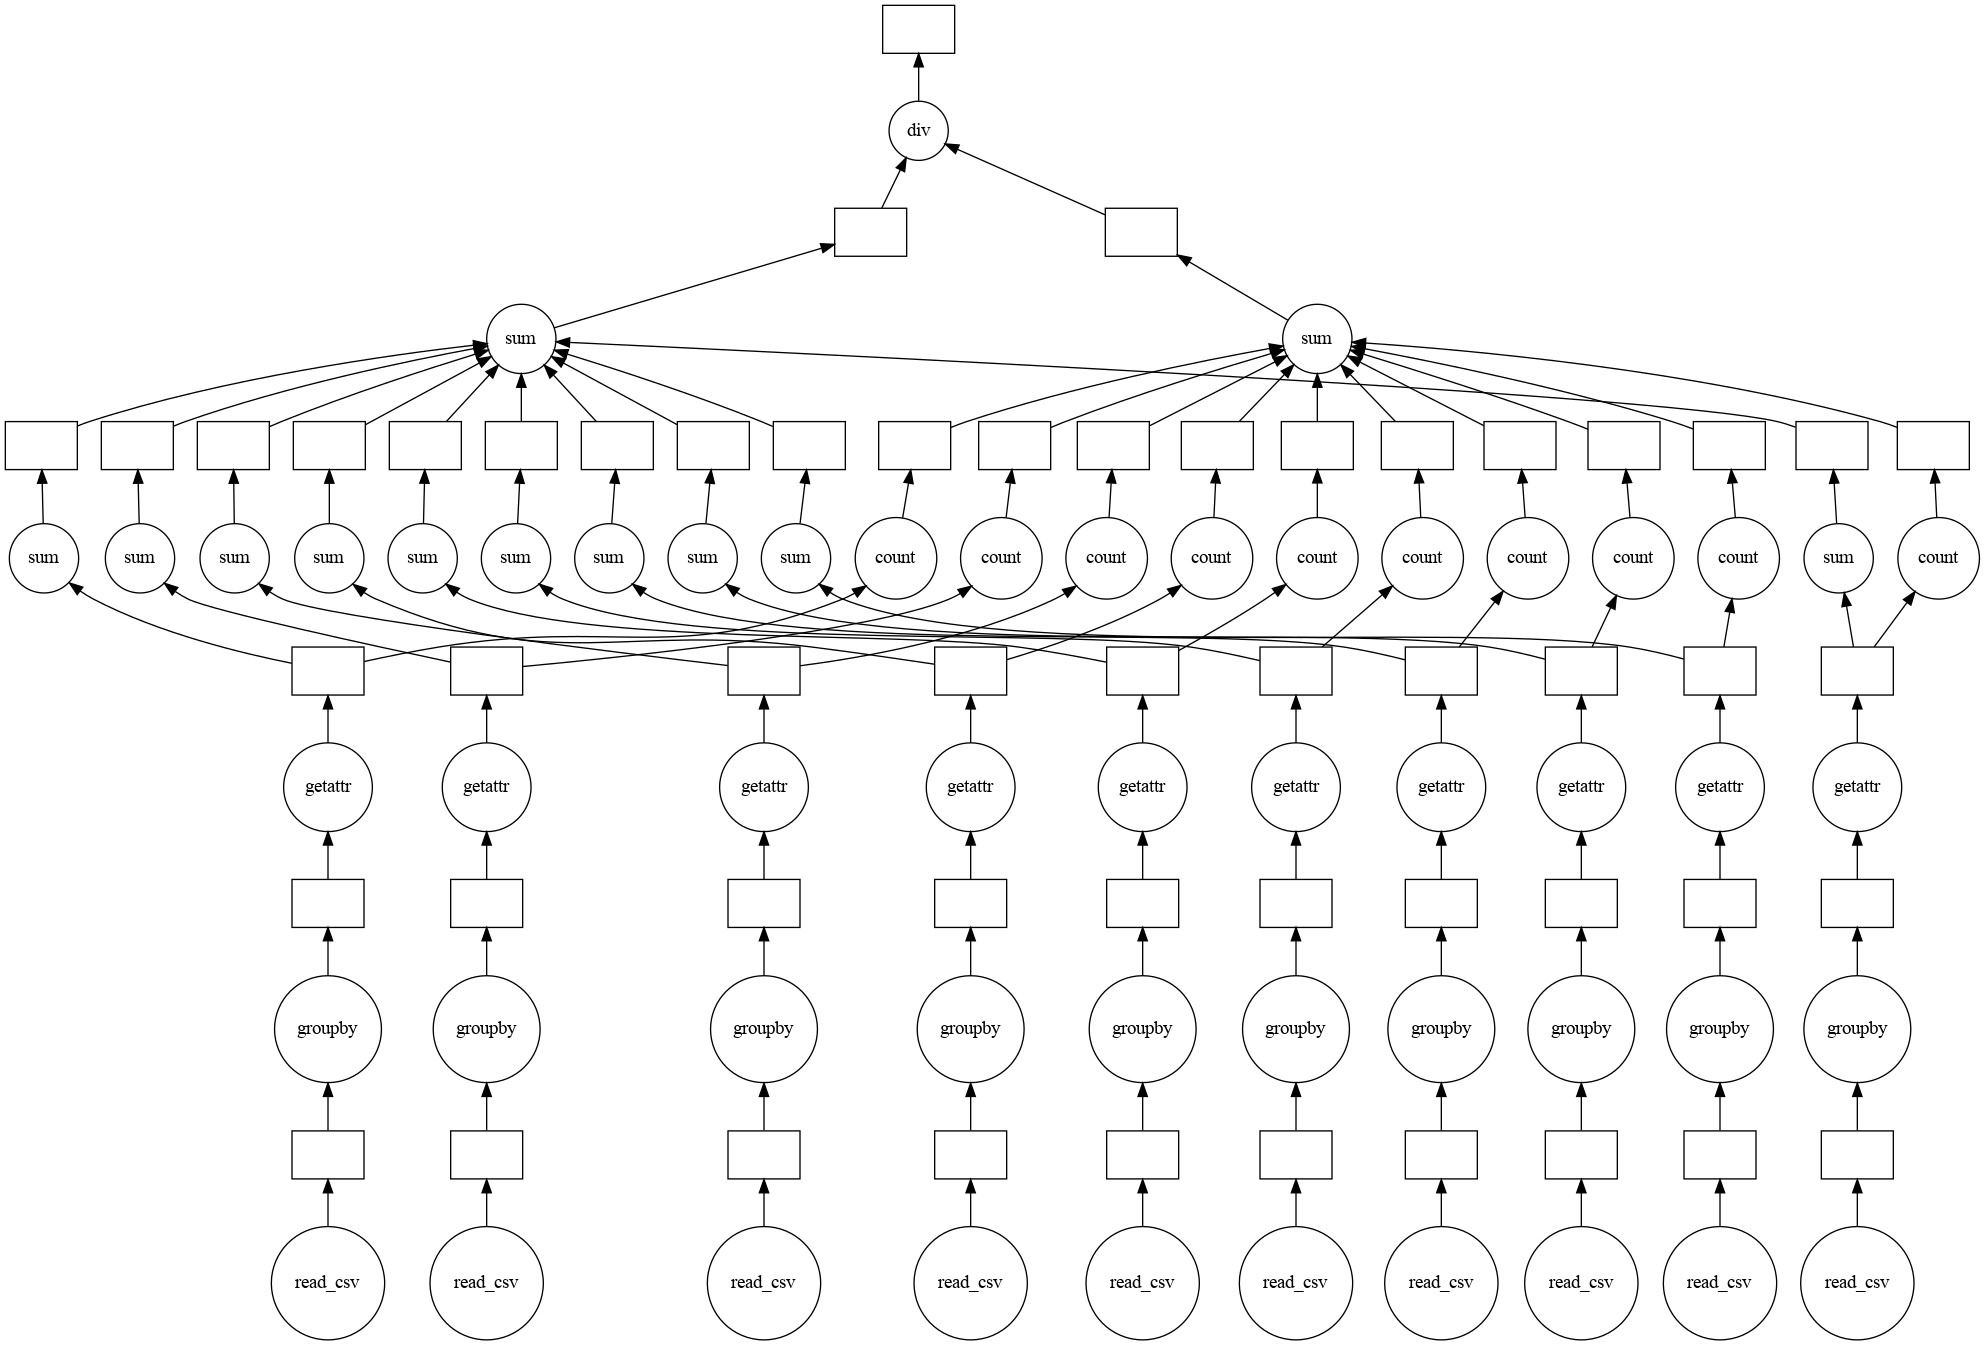

In [55]:
mean.visualize()

If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [56]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 191 ms, sys: 8.41 ms, total: 199 ms
Wall time: 1.55 s


In [61]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

## 要考虑的一些问题：

- 您获得了多少提速？ 这是您期望的加速速度吗？
- 尝试在何处调用`compute`。 当您用`sums`和`counts`调用它时会发生什么？ 如果您等待并按`mean`调用该怎么办？
- 尝试delaying call `sum`。 如果`sum`被延迟，图形将是什么样？ 如果不是，则图形看起来像什么？
- 您能想出为什么要以一种方式比另一种方式进行规约的任何原因吗？

### Learn More

Visit the [Delayed documentation](https://docs.dask.org/en/latest/delayed.html). In particular, this [delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU) will reinforce the concepts you learned here and the [delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) document collects advice on using `dask.delayed` well.

## Close the Client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [63]:
client.close()  #最开头的client关闭